# Getting started with DoWhy: A simple example
This is a quick introduction to the DoWhy causal inference library.
We will load in a sample dataset and estimate the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable.

First, let us add the required path for Python to find the DoWhy code and load all required packages.

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

Let's check the python version. 

In [2]:
print(sys.version)

3.5.2 (default, Jul 10 2019, 11:58:48) 
[GCC 5.4.0 20160609]


In [3]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

In [4]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_samples=10000, 
        treatment_is_binary=True)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

    Z0        Z1        X0        X1        X2        X3        X4    v  \
0  1.0  0.497037  0.457819 -0.122799 -1.008029 -0.593407 -1.662122  1.0   
1  0.0  0.124689 -0.787039  1.946060  0.860549  0.694571 -1.336487  1.0   
2  0.0  0.804227  0.341221 -0.270201  0.689100 -1.286903 -2.049364  1.0   
3  0.0  0.023383  0.216145  1.210546 -1.858824 -0.678202 -0.809396  1.0   
4  0.0  0.284569 -1.790000  2.213267 -0.539061 -0.476480 -0.941096  1.0   

           y  
0   6.098897  
1  11.891127  
2   8.033139  
3   6.218750  
4   7.096195  
digraph { v ->y; U[label="Unobserved Confounders"]; U->v; U->y;X0-> v; X1-> v; X2-> v; X3-> v; X4-> v;X0-> y; X1-> y; X2-> y; X3-> y; X4-> y;Z0-> v; Z1-> v;}


graph[directed 1node[ id "v" label "v"]node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "v" target "y"]edge[source "Unobserved Confounders" target "v"]edge[source "Unobserved Confounders" target "y"]node[ id "X0" label "X0"] edge[ source "X0" targe

Note that we are using a pandas dataframe to load the data. At present, DoWhy only supports pandas dataframe as input.

## Interface 1 (recommended): Input causal graph

We now input a causal graph in the GML graph format (recommended). You can also use the DOT format.

In [5]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v'] on outcome ['y']


In [6]:
model.view_model()

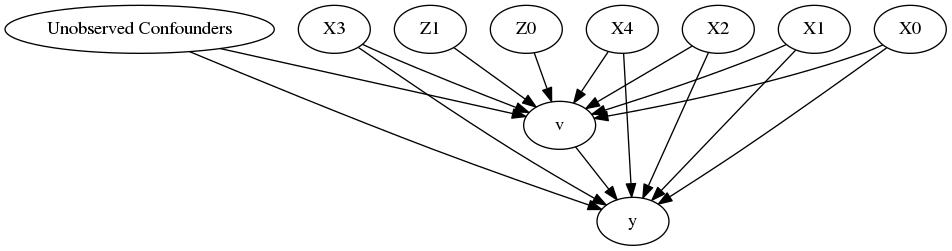

In [7]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify 
the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

**DoWhy philosophy: Keep identification and estimation separate**

Identification can be achieved without access to the data, acccesing only the graph. This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step.
It is important to understand that these are orthogonal steps.

* Identification

In [8]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Unobserved Confounders', 'X4', 'X3', 'X2', 'X0', 'X1']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                                
──(Expectation(y|X4,X3,X2,X0,X1))
dv                               
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X3,X2,X0,X1,U) = P(y|v,X4,X3,X2,X0,X1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v, Z1))
Estimand assumption 1, Exclusion: If we remove {Z1,Z0}→v, then ¬(Z1,Z0→y)
Estimand assumption 2, As-if-random: If U→→y then ¬(U →→Z1,Z0)



If you want to disable the warning for ignoring unobserved confounders, you can add a parameter flag ( *proceed\_when\_unidentifiable* ). The same parameter can also be added when instantiating the CausalModel object. 

In [9]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Unobserved Confounders', 'X4', 'X3', 'X2', 'X0', 'X1']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                                
──(Expectation(y|X4,X3,X2,X0,X1))
dv                               
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X3,X2,X0,X1,U) = P(y|v,X4,X3,X2,X0,X1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v, Z1))
Estimand assumption 1, Exclusion: If we remove {Z1,Z0}→v, then ¬(Z1,Z0→y)
Estimand assumption 2, As-if-random: If U→→y then ¬(U →→Z1,Z0)



* Estimation

In [10]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+X3+X2+X0+X1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                                
──(Expectation(y|X4,X3,X2,X0,X1))
dv                               
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X3,X2,X0,X1,U) = P(y|v,X4,X3,X2,X0,X1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v, Z1))
Estimand assumption 1, Exclusion: If we remove {Z1,Z0}→v, then ¬(Z1,Z0→y)
Estimand assumption 2, As-if-random: If U→→y then ¬(U →→Z1,Z0)

## Realized estimand
b: y~v+X4+X3+X2+X0+X1
## Estimate
Value: 10.073828188351905

## Effect Strength
Change in outcome attributable to treatment: 0.7113293862233037

Causal Estimate is 10.073828188351905


## Interface 2: Specify common causes and instruments

In [11]:
# Without graph                                       
model= CausalModel(                             
        data=df,                                      
        treatment=data["treatment_name"],             
        outcome=data["outcome_name"],                 
        common_causes=data["common_causes_names"])                         

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v'] on outcome ['y']


In [12]:
model.view_model()

<img src="causal_model.png" />

We get the same causal graph. Now identification and estimation is done as before.

In [13]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)                         

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['X4', 'X3', 'X2', 'U', 'X0', 'X1']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


* Estimation

In [14]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")         
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+X3+X2+X0+X1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                                
──(Expectation(y|X4,X3,X2,X0,X1))
dv                               
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X3,X2,X0,X1,U) = P(y|v,X4,X3,X2,X0,X1)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: y~v+X4+X3+X2+X0+X1
## Estimate
Value: 10.073828188351905

## Effect Strength
Change in outcome attributable to treatment: 0.7113293862233037

Causal Estimate is 10.073828188351905


## Refuting the estimate

Let us now look at ways of refuting the estimate obtained.

### Adding a random common cause variable

In [15]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+X3+X2+X0+X1+w_random


Refute: Add a Random Common Cause
Estimated effect:(10.073828188351905,)
New effect:(10.081278154772962,)



### Adding an unobserved common cause variable

In [16]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+X3+X2+X0+X1


Refute: Add an Unobserved Common Cause
Estimated effect:(10.073828188351905,)
New effect:(9.295165431674173,)



### Replacing treatment with a random (placebo) variable

In [17]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+X4+X3+X2+X0+X1


Refute: Use a Placebo Treatment
Estimated effect:(10.073828188351905,)
New effect:(0.061968119521972655,)



### Removing a random subset of the data

In [18]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+X3+X2+X0+X1


Refute: Use a subset of data
Estimated effect:(10.073828188351905,)
New effect:(10.077557800915583,)



As you can see, the propensity score stratification estimator is reasonably robust to refutations.
For reproducibility, you can add a parameter "random_seed" to any refutation method, as shown below.

In [19]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+X3+X2+X0+X1


Refute: Use a subset of data
Estimated effect:(10.073828188351905,)
New effect:(10.063835692652203,)

